# Simple Linear Regression with PyTorch

- $y=ax+b$ 를 PyTorch를 이용해 learning해 나가는 것을 graphical 하게 표현한다
- PyTorch에서 필요로 하는 기본중의 기본을 이 example에서 대략 설명
- `torch.nn.Parameter`를 사용하여 model을 만든다

- 알아야 할 점
    - 여기에서는 implicit하게 input이 Nx1 matrix인 것 처럼 처리하고, output도 Nx1 matrix인 것 처럼 처리해 준다
    - 즉 vector의 각 element를 별도의 row인 것 처럼 implicit하게 처리한다
    - 이게 왜 중요하냐면, MAE를 구할때 vector를 1xN 인것 처럼 생각하면 각각의 에러를 구한 후 그것을 더한 값이 MAE가 되지만, Nx1인것 처럼 생각하면 각각의 에러를 구한 후 그것의 mean을 취한 것이 MAE가 된다
    - 즉 여기에서 저렇게 implicit하게 해 주지 않았다면 에러가 터무니 없이 커져서 (training set크기만큼 error를 전부다 더해 버릴 테니까) training이 제대로 되지 않았을 거라는 이야기이다
    - 02_simple_linear_regression_with_torch_linear는 Parameter가 아니라 Tensor를 직접 사용하기 때문에 이 부분에 대한 고려가 반드시 되어야 똑바로 나온다. 안 그러면 에러가 엄청나게 커져서 training이 이상하게 된다

In [34]:
# 1. 일단 import

import matplotlib.pyplot
import numpy
import torch
import sklearn.model_selection

x_train.shape = torch.Size([1600])
y_train.shape = torch.Size([1600])
x_test.shape  = torch.Size([400])
y_test.shape  = torch.Size([400])


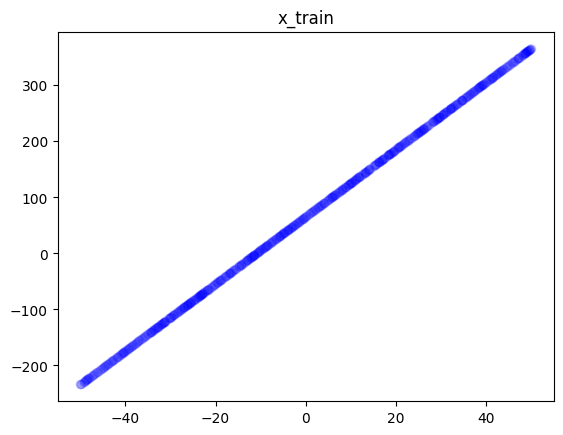

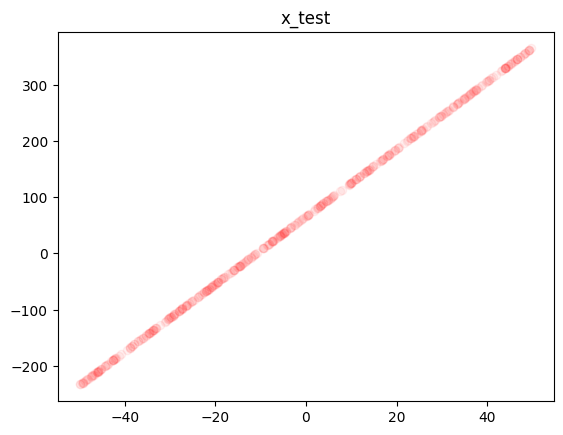

In [35]:
# 2. 데이터 생성

numpy.random.seed(20231213)

n = 2000
x = (numpy.random.rand(n) - 0.5) * 100 # -50 ~ 50
weight = 6
bias = 66

# x = numpy.random.rand(n)
# weight = 0.7
# bias = 0.3

y = (weight * x) + bias

# 기본적으로 numpy는 float64로 생성되므로 float32로 변환해 준다
x = x.astype(numpy.float32)
y = y.astype(numpy.float32)

# sklearn.model_selection.train_test_split을 이용하면 편리하게
# train, test 데이터를 나눌 수 있다
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.2)

# numpy인 채로 사용하면 RuntimeError: Can't call numpy() on Tensor that requires grad
# 라고 나온다. 그래서 torch.from_numpy로 변환해 주어야 한다. 자동으로 변환은 안 되는 듯?
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test  = torch.from_numpy(x_test)
y_test  = torch.from_numpy(y_test)

print(f'x_train.shape = {x_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'x_test.shape  = {x_test.shape}')
print(f'y_test.shape  = {y_test.shape}')

# data는 반드시 visualization을 한번 해 보는 것이 좋다
# (물론 이번에는 매우매우 뻔한 데이터이기는 하지만)

# 찍어 보면 2000 정도로는 생각보다 uniform 하지 않다는 걸 알 수 있음

matplotlib.pyplot.title('x_train')
matplotlib.pyplot.scatter(x_train, y_train, alpha=0.05, color='blue')
matplotlib.pyplot.show()

matplotlib.pyplot.title('x_test')
matplotlib.pyplot.scatter(x_test, y_test, alpha=0.05, color='red')
matplotlib.pyplot.show()  

In [36]:
# 3. 모델 생성

# torch.nn.Module은 torch에서 모델을 만들 때 상속받아야 하는 class
class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # weights, bias는 모두 random value로 시작
        # requires_grad=True로 설정해야 gradient track이 된다
        self.weights = torch.nn.Parameter(
            torch.randn(1, dtype=torch.float, requires_grad=True)
        )
        self.bias = torch.nn.Parameter(
            torch.randn(1, dtype=torch.float, requires_grad=True)
        )
    
    # 모든 nn.Module subclass는 forward method를 구현해야 한다
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        # linear regression model을 적용
        # 1차원 vector를 받아 1차원 vector를 반환한다
        return (self.weights * x) + self.bias

# 모델 내부 들여다 보기

model_example = LinearRegressionModel()
print(f'list(model_example.parameters()):')
for i,p in enumerate(model_example.parameters()):
    print(f'({i}){p}')
print()
print(f'model_example.state_dict():')
print(f'{model_example.state_dict()}')

list(model_example.parameters()):
(0)Parameter containing:
tensor([0.5046], requires_grad=True)
(1)Parameter containing:
tensor([-0.7784], requires_grad=True)

model_example.state_dict():
OrderedDict([('weights', tensor([0.5046])), ('bias', tensor([-0.7784]))])


In [37]:
# 4. 모델 학습

def do_training(epochs, cls_model, cls_loss_func, cls_optimizer, x_train, y_train, x_test, y_test):
    model = cls_model()
    loss_func = cls_loss_func() 
    optimizer = cls_optimizer(params = model.parameters(), lr=0.1)

    result = []

    # model을 training mode로 설정한다. 사실 default mode
    model.train()

    for e in range(epochs):
        # 1. forward pass 실행
        y_pred = model(x_train) 
        # 2. loss 계산
        loss = loss_func(y_pred, y_train) 

        if e == 0:
            print(f'y_pred.shape = {y_pred.shape}')
            print(f'y_train.shape = {y_train.shape}')
            print(f'loss = {loss}')
            print(f'loss.shape = {loss.shape}')

        # 3. gradient 초기화. 이걸 안하면 gradient가 누적된다고 한다
        optimizer.zero_grad()
        # 4. 각 요소의 gradient contribution을 계산한다 
        loss.backward() 
        # 5. gradient descent를 실제 실행한다
        optimizer.step() 
        
        if e % 10 == 0:
            model.eval() # model을 evaluation mode로 설정한다
            with torch.inference_mode():
                train_loss = loss.clone().detach()
                y_pred_test = model(x_test).clone().detach()
                test_loss = loss_func(y_pred_test, y_test).clone().detach()

                # print(f'epoch: {e}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}')
                # print(f'weights: {model.weights}, bias: {model.bias}')
                result.append((e, train_loss, y_pred_test, test_loss))

            model.train() # model을 training mode로 원상 복구
    
    return result

def draw_loss_graph(train_result):
    arr_epoch = [e for e, _, _, _ in train_result]
    arr_train_loss = [l for _, l, _, _ in train_result]
    arr_test_loss = [l for _, _, _, l in train_result]

    matplotlib.pyplot.title('loss')
    matplotlib.pyplot.plot(arr_epoch, arr_train_loss, color='blue', label='train_loss')
    matplotlib.pyplot.plot(arr_epoch, arr_test_loss, color='red', label='test_loss')
    matplotlib.pyplot.legend()
    matplotlib.pyplot.show()

def draw_test_result_change(epochs, train_result):
    matplotlib.pyplot.title('x_test')

    for e, _, y_pred_test, _ in train_result:
        # print(e,epochs)
        g = int(255 * (e / float(epochs)))
        b = int(255 * (1.0 - (e / float(epochs))))
        # print(g,b)
        cur_c = f'#00{g:02x}{b:02x}'
        # print(cur_c)
        matplotlib.pyplot.scatter(x_test, y_pred_test, alpha=0.1, color=cur_c)
        
    matplotlib.pyplot.scatter(x_test, y_test, alpha=0.1, color='red')
    matplotlib.pyplot.show()

y_pred.shape = torch.Size([1600])
y_train.shape = torch.Size([1600])
loss = 166.44085693359375
loss.shape = torch.Size([])


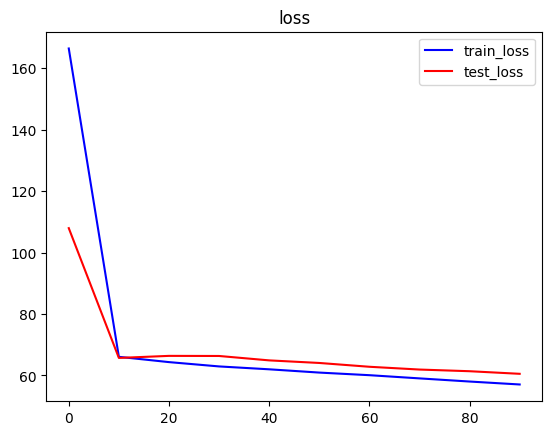

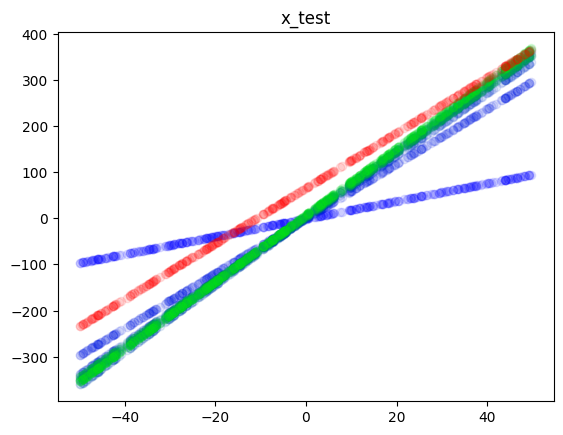

In [38]:
# Test 1
cls_model = LinearRegressionModel
cls_loss_func = torch.nn.L1Loss # L1 loss = MAE
cls_optimizer = torch.optim.SGD # stochastic gradient descent

# epoch 100으로는 생각보다 좋게 안나오는걸 알 수 있음
epochs = 100
train_result = do_training(epochs, cls_model, cls_loss_func, cls_optimizer, x_train, y_train, x_test, y_test)
draw_loss_graph(train_result)
draw_test_result_change(epochs, train_result)

y_pred.shape = torch.Size([1600])
y_train.shape = torch.Size([1600])
loss = 141.42083740234375
loss.shape = torch.Size([])


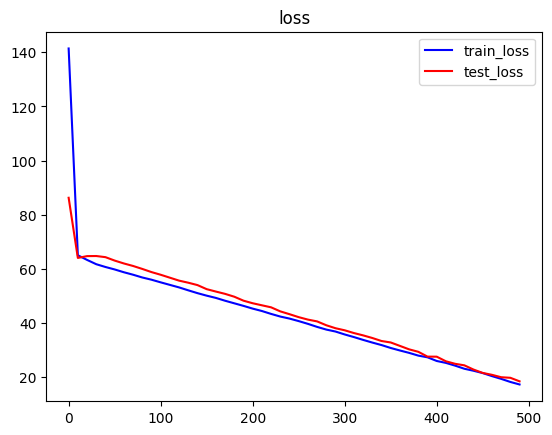

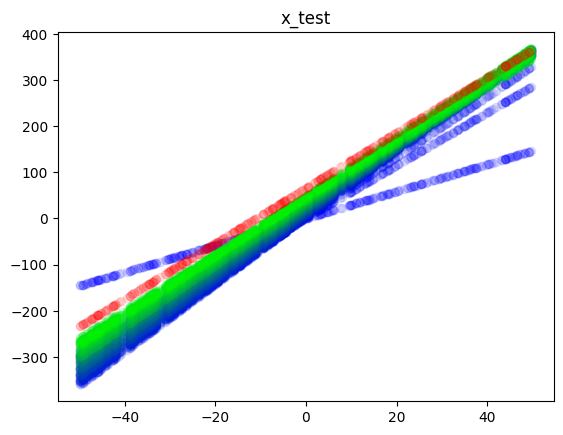

In [39]:
# epoch 500 까지는 좋아진다

epochs = 500
train_result = do_training(epochs, cls_model, cls_loss_func, cls_optimizer, x_train, y_train, x_test, y_test)
draw_loss_graph(train_result)
draw_test_result_change(epochs, train_result)

y_pred.shape = torch.Size([1600])
y_train.shape = torch.Size([1600])
loss = 134.77394104003906
loss.shape = torch.Size([])


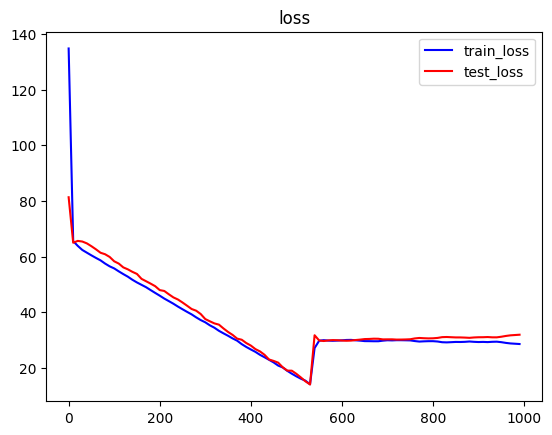

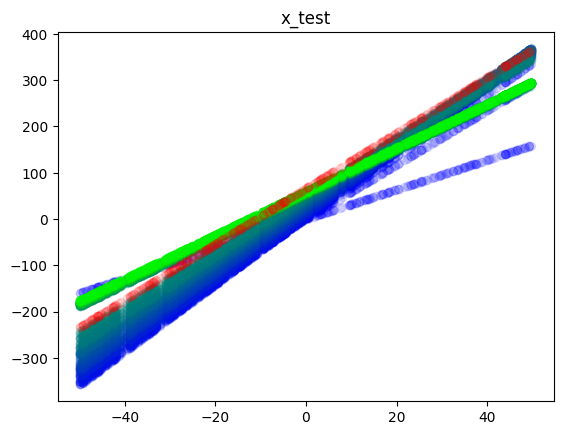

In [40]:
# 근데 epochs가 500이 넘어가면 갑자기 안좋아 짐. 뭔가 모델의 한계? 많이 쑤셔넣는다고 좋은게 아니라는걸 보여줌

epochs = 1000
train_result = do_training(epochs, cls_model, cls_loss_func, cls_optimizer, x_train, y_train, x_test, y_test)
draw_loss_graph(train_result)
draw_test_result_change(epochs, train_result)

y_pred.shape = torch.Size([1600])
y_train.shape = torch.Size([1600])
loss = 156.32423400878906
loss.shape = torch.Size([])


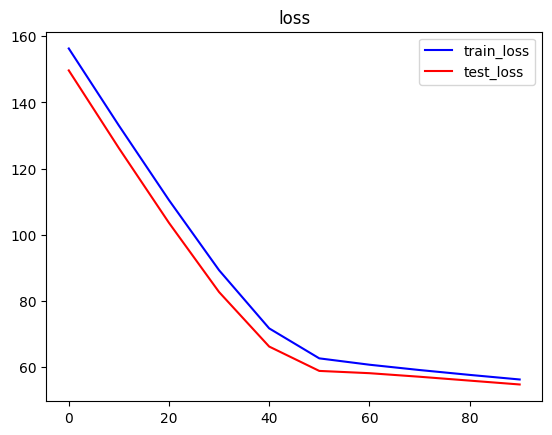

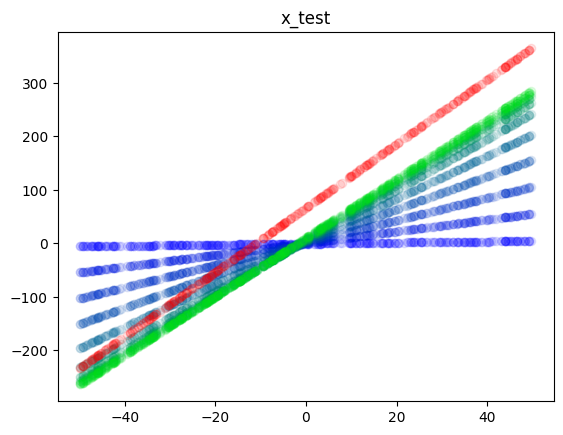

In [41]:
# Test 2 
# 여기서는 Adam을 사용해 보자

cls_loss_func = torch.nn.L1Loss # L1 loss = MAE
cls_optimizer = torch.optim.Adam

epochs = 100
train_result = do_training(epochs, cls_model, cls_loss_func, cls_optimizer, x_train, y_train, x_test, y_test)
draw_loss_graph(train_result)  # loss 를 보면 생각보다 SGD에 비해 loss 자체는 별 차이 없음
draw_test_result_change(epochs, train_result) # 그래프를 보면 좀 더 smooth하게 배워 나간다는걸 알 수 있다

y_pred.shape = torch.Size([1600])
y_train.shape = torch.Size([1600])
loss = 183.74420166015625
loss.shape = torch.Size([])


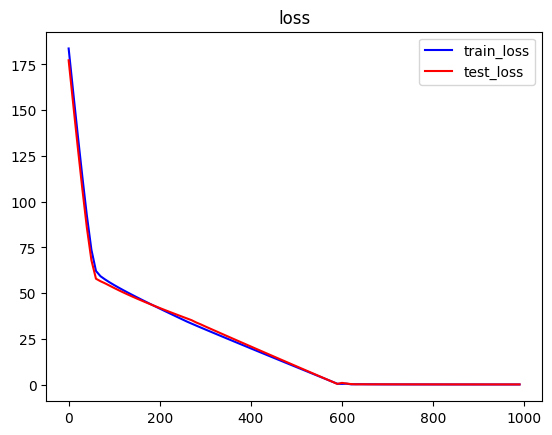

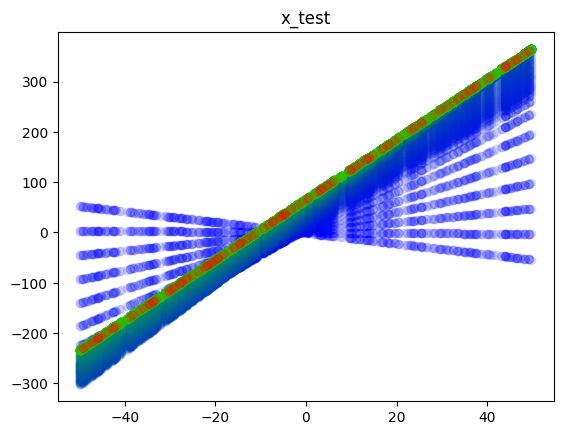

In [42]:
# 그러나 epoch을 1000까지 올린다면 Adam이 확실히 더 좋다는걸 알 수 있다
# 결국 0 까지 떨어진다는 걸 볼 수 있음
# optimizer가 매우 중요하긴 중요하다 + 이것저것 테스트 해보고 볼 일이다

epochs = 1000

train_result = do_training(epochs, cls_model, cls_loss_func, cls_optimizer, x_train, y_train, x_test, y_test)

# 이 그래프를 보면 RMSProp덕분인지 어느 순간에 learning rate가 자동으로 조절 되는걸 볼 수 있다
draw_loss_graph(train_result)  

# SGD와는 달리 결국 거의 같은 function에 까지 도달해 낸다
draw_test_result_change(epochs, train_result) 